In [2]:
!pip install wordcloud
!pip install nltk
!pip install emoji
!pip install demoji
import os
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk import FreqDist
import nltk
import re
import csv
from wordcloud import WordCloud, STOPWORDS

In [3]:

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))


df_posts = pd.read_csv('../data/senti_posts.zip').drop(6161)
df_posts['timestamp'] = pd.to_datetime(df_posts['timestamp'])
df_posts['score'] = pd.to_numeric(df_posts['score'])
df_posts['hour_day'] = pd.to_datetime(df_posts['timestamp'].dt.strftime('%Y-%m-%dT%H'))
df_posts = df_posts[df_posts['hour_day'] >= '2021-01-29']
df_posts['title'] = df_posts['title'].fillna('')
df_posts['body'] = df_posts['body'].fillna('')


df_comments = pd.read_csv('../data/senti_comments.zip', lineterminator='\n') \
    .merge(df_posts[['id', 'hour_day']], left_on='id_col', right_on='id') \
    .drop('id', axis=1)
df_comments = df_comments[df_comments['hour_day'] >= '2021-01-29']
df_comments['comments'] = df_comments['comments'].fillna('')

# Join the 'title' and 'body' columns
df_posts['combined_text'] = df_posts['title'] + ' ' + df_posts['body']


# Create a new DataFrame with the desired columns from df_posts
df_combined = pd.DataFrame({
    'text': df_posts['combined_text'].fillna(''),
    'id': df_posts['id'],
    'sent_label': df_posts['sent_label'],
    'sent_score': df_posts['sent_score']
})

# Create a new DataFrame with the desired columns from df_comments
df_comments_combined = pd.DataFrame({
    'text': df_comments['comments'].fillna(''),
    'id': df_comments['id_col'],
    'sent_label': df_comments['sent_label'],
    'sent_score': df_comments['sent_score']
})

# Concatenate df_combined and df_comments_combined
df_combined = pd.concat([df_combined, df_comments_combined], ignore_index=True)


# Create a dataframe for positive labels
df_positive = df_combined[df_combined['sent_label'] == 'positive']
df_positive = df_positive.reset_index(drop=True)
# Create a dataframe for negative labels
df_negative = df_combined[df_combined['sent_label'] == 'negative']
df_negative = df_negative.reset_index(drop=True)

df_negative.head()


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,id,sent_label,sent_score
0,Current data on GME short positions Is there d...,l6yxto,negative,0.990254
1,xspa anything on xspa stock i thought itll soa...,l6yxjc,negative,0.997744
2,YOU CAN BUY THROUGH top 100 list !!!!!! On RH ...,l6yx9c,negative,0.975635
3,WHATS THIS BULLSHIT WHY CANT I BUY MORE SHARES...,l6yx91,negative,0.998956
4,THE MOVIE A BUGS LIFE WARNED ABOUT THESE FUCKS...,l6yx8r,negative,0.998236


In [4]:
def clean_text(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                   
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

/tmp/ipykernel_258/138948259.py:40: UserWarning: Glyph 128 (\x80) missing from current font.
  plt.savefig('most_frequent_words.png', transparent=True)
/tmp/ipykernel_258/138948259.py:40: UserWarning: Glyph 153 (\x99) missing from current font.
  plt.savefig('most_frequent_words.png', transparent=True)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


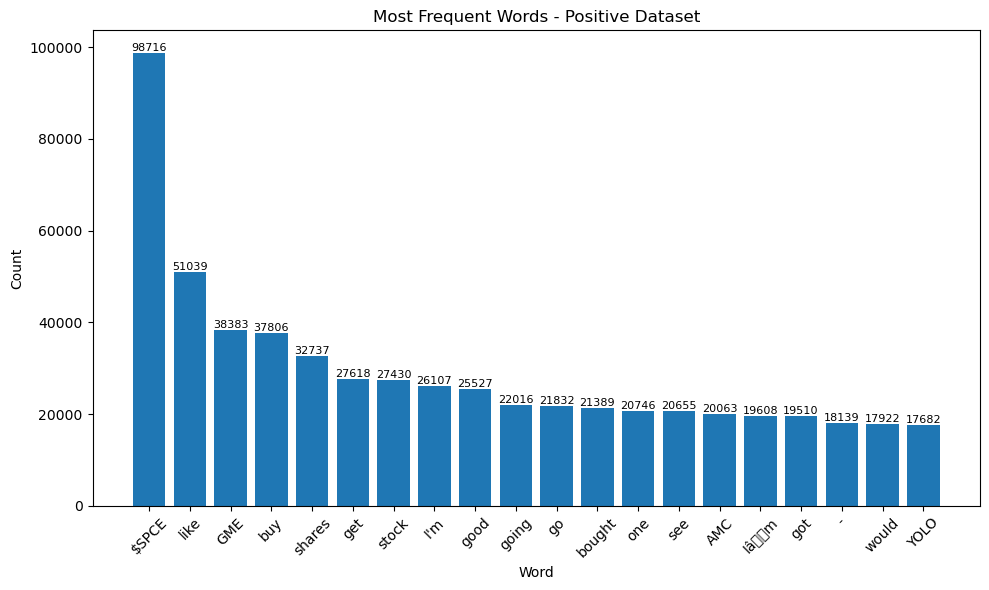

In [16]:


# Function to remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(words)


# Remove stopwords from the 'text' column in df_negative
df_positive['cleaned_text'] = df_positive['text'].apply(remove_stopwords)

# Join all the cleaned texts into a single string
positive_text = ' '.join(df_positive['cleaned_text'])

# Split the string of words into a list
words = positive_text.split()

# Count the frequency of each word
positive_freqdist = FreqDist(words)

# Get the most common words and their counts
positive_common = positive_freqdist.most_common(20)

# Create a DataFrame for comparison
df_common = pd.DataFrame(positive_common, columns=['Word', 'Count'])

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.bar(df_common['Word'], df_common['Count'])
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Frequent Words - Positive Dataset')
plt.xticks(rotation=45)

# Add numbers on the bars
for i, count in enumerate(df_common['Count']):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=8)

# Save the plot as a transparent image
plt.savefig('most_frequent_words.png', transparent=True)

# Display the plot
plt.tight_layout()

plt.show()

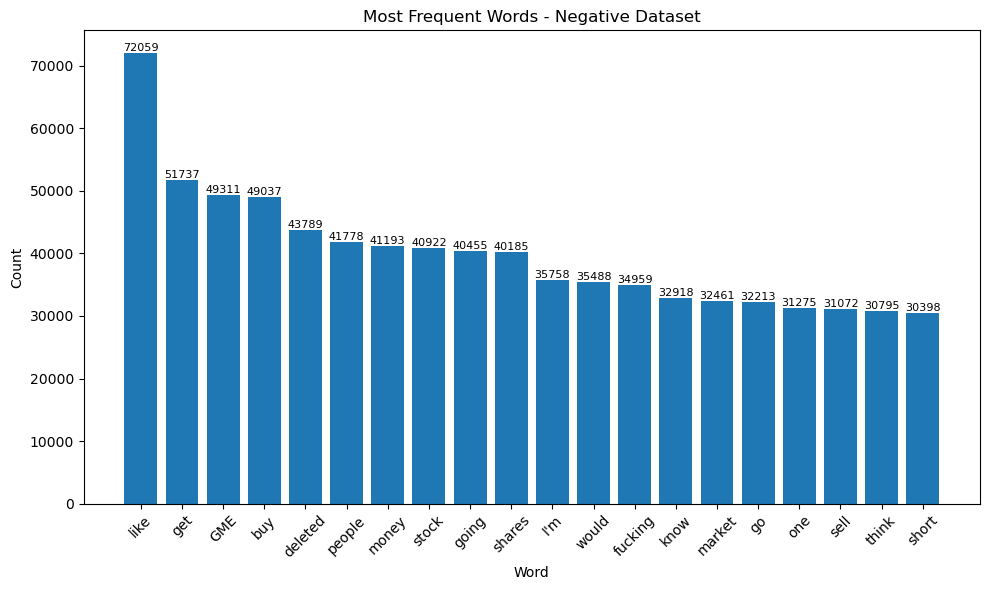

In [11]:

# Function to remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(words)

# Remove stopwords from the 'text' column in df_negative
df_negative['cleaned_text'] = df_negative['text'].apply(remove_stopwords)

# Join all the cleaned texts into a single string
negative_text = ' '.join(df_negative['cleaned_text'])

# Split the string of words into a list
words = negative_text.split()

# Count the frequency of each word
negative_freqdist = FreqDist(words)

# Get the most common words and their counts
negative_common = negative_freqdist.most_common(20)

# Create a DataFrame for comparison
df_common = pd.DataFrame(negative_common, columns=['Word', 'Count'])

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.bar(df_common['Word'], df_common['Count'])
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Frequent Words - Negative Dataset')
plt.xticks(rotation=45)

# Add numbers on the bars
for i, count in enumerate(df_common['Count']):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=8)


# Save the plot as a transparent image
plt.savefig('most_frequent_words_negative.png', transparent=True)

# Display the plot
plt.tight_layout()
plt.show()
